In [17]:
import pandas as pd
import numpy as np
import keras
import tensorflow
import matplotlib.pyplot as plt
import cv2
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# `Define constants`

In [4]:
FRAMES = 18
IMG_SIZE = 224

# `1 - Build feature extractor`

In [5]:
from keras import applications


def build_feature_extractor():
    InceptionV3_model = applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3), )

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocess_input = keras.applications.inception_v3.preprocess_input(inputs)
    outputs = InceptionV3_model(preprocess_input)
    myModel = keras.Model(inputs, outputs, name="feature_extractor")
    return myModel


feature_extractor = build_feature_extractor()


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



# `2 - Prepare the data`

The data is very small and is highly variant which makes it difficult to train our model. To overcome this we will put each image into a featurizer that extracts important features of the image.

In our case, since we mainly care about the hand gestures we will use Media Pipe 


### Extracting `hand pose estimations` using `MediaPipe` and then extract the features

In [8]:
# Define a function to extract features from a video

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def detect_hand(img):
    img_copy = np.zeros(img.shape)
    results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    spec = mp_drawing.DrawingSpec(thickness=0, circle_radius=0)
    spec2 = mp_drawing.DrawingSpec(color = (161,61,45))
    if results.multi_hand_landmarks:
        for hand_no, hand_landmarks in enumerate(results.multi_hand_landmarks):
            mp_drawing.draw_landmarks(image = img_copy, landmark_list = hand_landmarks,
                                      connections = mp_hands.HAND_CONNECTIONS, landmark_drawing_spec = spec,
                                      connection_drawing_spec = spec2)
    return img_copy

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### `Plot before and after feature extraction`

/opt/miniconda3/lib/python3.9/site-packages/google/protobuf/symbol_database.py:78: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


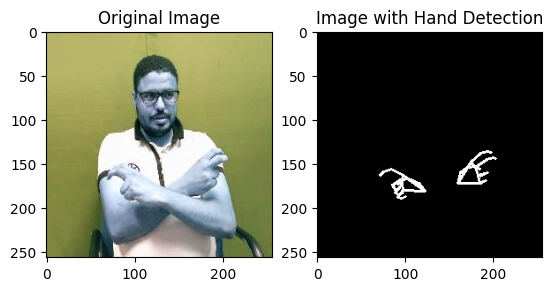

In [18]:
# Reading the sample image on which we will perform the detection
sample_img = cv2.imread('../data/03/train/0071/03_03_0071_(13_12_16_17_41_27)/03_03_0071_(13_12_16_17_41_27)_c_0020.jpg')

fig, ax = plt.subplots(1, 2)
plt.imshow(sample_img)
ax[0].imshow(sample_img)
ax[0].set_title('Original Image')

ax[1].imshow(detect_hand(sample_img))
ax[1].set_title('Image with Hand Detection')
plt.show()


### `Apply on the whole dataset`

In [21]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import glob

source_dirs = ['../data/03/train', '../data/01/test', '../data/02/test', '../data/03/test']
save_dirs = ['../data/03_hand/train', '../data/01_hand/test', '../data/02_hand/test', '../data/03_hand/test']
[os.makedirs(save_dir) for save_dir in save_dirs if not os.path.exists(save_dir)]

for source_dir,save_dir in zip(source_dirs, save_dirs):
    for sign in os.listdir(source_dir):
        for video in os.listdir(os.path.join(source_dir, sign)):
            video_path = os.path.join(source_dir, sign, video)
            video_data = [cv2.resize(detect_hand(cv2.imread(file)), (224,224)) for file in glob.glob(f"{video_path}/*.jpg")]
            video_data = np.array(video_data)
            video_data = video_data.astype('float32')
            video_data = video_data / 255.0
            video_features = feature_extractor.predict(video_data)
            save_path = os.path.join(save_dir, sign)
            if not os.path.exists(save_path): os.makedirs(save_path)
            video_features_path = os.path.join(save_path, video + '.npy')
            np.save(video_features_path, video_features)
            # os.remove(video_path)

1/1 [==============================] - 0s 39ms/step


# `3 - Postprocessing`

### 1 - Some labels do not share the base number of videos `( 35 )`, so, we found the max and padded the rest till they `reached the max`. The padding was done using the `last sample` in the label.

In [22]:
import os

data_dir = ['../data/01_hand/', '../data/02_hand/', '../data/03_hand/']
max_len_dic = {i: 0 for i in os.listdir('../data/01_hand/train')}
max_samples = 0

for data in data_dir:
    for dataset in os.listdir(data):
        signer = os.path.join(data, dataset)
        for label in os.listdir(signer):
            # Number of files in the label directory
            label_dir = os.path.join(signer, label)
            count_files = len(os.listdir(label_dir))
            max_len_dic[label] = max(max_len_dic[label], count_files)
    
max_len_dic


for data in data_dir:
    for dataset in os.listdir(data):
        signer = os.path.join(data, dataset)
        for label in os.listdir(signer):
            # Number of files in the label directory
            label_dir = os.path.join(signer, label)
            count_files = len(os.listdir(label_dir))
            if count_files < max_len_dic[label]:
                #load the last sample in the folder 
                padding_sample = np.load(os.path.join(label_dir, os.listdir(label_dir)[-1]))
                for i in range(max_len_dic[label] - count_files):
                    np.save(os.path.join(label_dir, str(i) + '.npy'), padding_sample)

### 2 - Some of the videos were 10, 15 frames, so we padded them to match the base `( 18 )` frames using the `last frame` in the video.

In [19]:
data_dir = '../data/01_hand/train'

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    for file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, file)
        a = np.load(file_path)
        if a.shape != (18, 2048):
            padding = a[-1]
            a = np.concatenate((a, np.tile(padding, (18-a.shape[0], 1))))
            np.save(file_path, a)        

# `4 - Create the validation set`

In [25]:
import os
import random
import shutil

# Set the base path to the train folder
base_path = '../data/03_hand/train'

# Create a list of all subdirectories in the train folder
subdirs = [x[0] for x in os.walk(base_path)]

# Remove the base path from the list of subdirectories
subdirs = subdirs[1:]

# Create a validation folder
validation_path = '../data/03_hand/validation'
if not os.path.exists(validation_path): os.makedirs(validation_path)


# Set the percentage of samples to move to the validation folder
validation_percentage = 0.2

# Iterate through each subdirectory
for subdir in subdirs:
    print(subdir)
    # Get the list of files in the subdirectory
    file_list = os.listdir(subdir)
    # Calculate the number of files to move to the validation folder
    num_validation_files = int(len(file_list) * validation_percentage)
    # Randomly select the files to move
    validation_files = random.sample(file_list, num_validation_files)
    place = subdir.replace('train', 'validation')
    if not os.path.exists(place): os.makedirs(place)
    for f in validation_files:
        print(f)
        # Move the file from the train subdirectory to the validation folder
        shutil.move(os.path.join(subdir, f), place)


../data/03_hand/train\0071
03_03_0071_(13_12_16_17_43_12).npy
03_03_0071_(13_12_16_17_43_17).npy
03_03_0071_(13_12_16_17_42_23).npy
03_03_0071_(15_12_16_16_11_57).npy
03_03_0071_(15_12_16_16_11_20).npy
03_03_0071_(13_12_16_17_43_22).npy
03_03_0071_(13_12_16_17_43_02).npy
../data/03_hand/train\0072
03_03_0072_(15_12_16_16_15_56).npy
03_03_0072_(15_12_16_16_14_59).npy
03_03_0072_(15_12_16_16_15_32).npy
03_03_0072_(13_12_16_17_46_47).npy
03_03_0072_(13_12_16_17_46_08).npy
03_03_0072_(13_12_16_17_46_42).npy
03_03_0072_(15_12_16_16_14_08).npy
../data/03_hand/train\0073
03_03_0073_(13_12_16_17_48_10).npy
03_03_0073_(13_12_16_17_50_19).npy
03_03_0073_(15_12_16_16_16_49).npy
03_03_0073_(13_12_16_17_49_28).npy
03_03_0073_(15_12_16_16_16_45).npy
03_03_0073_(15_12_16_16_17_23).npy
03_03_0073_(15_12_16_16_17_15).npy
../data/03_hand/train\0074
03_03_0074_(15_12_16_16_19_20).npy
03_03_0074_(15_12_16_16_19_36).npy
03_03_0074_(13_12_16_17_51_29).npy
03_03_0074_(15_12_16_16_19_58).npy
03_03_0074_(15_12

# ` 5 - The rest of the code which include model building can be found in main.ipynb `